## Benchmark IN-trained classifiers on `ImageNet-Hard`

<a target="_blank" href="https://colab.research.google.com/github/taesiri/ZoomIsAllYouNeed/blob/main/src/ImageNet_Hard/Benchmark-ImageNet-Hard.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

* [Website](https://taesiri.github.io/ZoomIsAllYouNeed/)
* [Github](https://github.com/taesiri/ZoomIsAllYouNeed)

In [1]:
!pip install transformers datasets timm

In [2]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from datasets import load_dataset
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

sns.set_style("whitegrid")

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(device=0))
print(torch.__version__)

8
NVIDIA A100-SXM4-40GB
1.11.0


## Transforms

In [4]:
standard_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

## Datasets


In [5]:
imagenet_hard_dataset = load_dataset("taesiri/imagenet-hard", split="validation")
imagenet_hard_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/13925 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/mohammad/.cache/huggingface/datasets/taesiri___parquet/taesiri--imagenet-hard2-683b1b5f67d261a0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label', 'origin', 'english_label'],
    num_rows: 13925
})

In [6]:
def apply_transforms(examples):
    examples["pixel_values"] = examples["image"]
    examples["image"] = [standard_transform(image) for image in examples["image"]]
    return examples


imagenet_hard_dataset.set_transform(apply_transforms)

## Benchmark

In [7]:
def collate_fn(batch):
    
    labels = [item["label"] for item in batch]
    labels = [label + [-1] * (10 - len(label)) for label in labels]
    
    return {
        "image": torch.stack([item["image"] for item in batch]),
        "label": torch.tensor(labels),
    }


loader = DataLoader(
    imagenet_hard_dataset, batch_size=32, num_workers=2, collate_fn=collate_fn
)


def run_benchmark(model, loader=loader, bs=16):
    model.cuda()
    model.eval()

    correct_ones = 0
    with torch.inference_mode():
        for i, (batch) in enumerate(tqdm(loader)):
            images, target = batch["image"], batch["label"]
            images = images.cuda()
            target = target.cuda()

            model_output = model(images)
            pred = model_output.data.max(1)[1]
            # correct_ones += pred.eq(target.data).sum().item()
            # accept correct if pred is one of the target labels
            correct_ones += (pred[:, None] == target).any(1).sum().item()
            
    return 100 * correct_ones / len(imagenet_hard_dataset)

In [8]:
model_names = ["resnet50", "resnet18", "alexnet", "vgg19", "vit_b_32"]

In [9]:
accuracy = {}

for name in model_names:
    model = models.__dict__[name](pretrained=True)
    accuracy[name] = run_benchmark(model)
    print(f"{name} accuracy: {accuracy[name]}")

100%|██████████| 436/436 [02:56<00:00,  2.47it/s]


resnet50 accuracy: 12.29443447037702


100%|██████████| 436/436 [02:55<00:00,  2.49it/s]


resnet18 accuracy: 9.213644524236983


100%|██████████| 436/436 [02:54<00:00,  2.49it/s]


alexnet accuracy: 6.240574506283663


100%|██████████| 436/436 [02:55<00:00,  2.48it/s]


vgg19 accuracy: 10.111310592459605


100%|██████████| 436/436 [02:54<00:00,  2.50it/s]

vit_b_32 accuracy: 15.62657091561939


In [10]:
pd.DataFrame(accuracy, index=["accuracy"]).T.round(2)

,accuracy
resnet50,12.29
resnet18,9.21
alexnet,6.24
vgg19,10.11
vit_b_32,15.63


## Visualization

In [11]:
url = "https://gist.githubusercontent.com/taesiri/5b5edb5452f2f20d82d5ed1bb58ab574/raw/0376003d3999799f99208fb338cfd06ee44372b5/imagenet-labels.json"

response = requests.get(url)

if response.status_code == 200:
    id_class = response.json()

id_class = {i: v for i, v in enumerate(id_class)}

format_str = (
    lambda x: x.replace("_", " ")
    .replace("-", " ")
    .replace("(", "")
    .replace(")", "")
    .replace("  ", " ")
    .strip()
    .lower()
)
id_class = {int(k): format_str(v) for k, v in id_class.items()}


In [12]:
# output top 5 predictions
def predict(model, image, k=5):
    model.eval()
    model.cuda()
    image = image.cuda().unsqueeze(0)
    with torch.inference_mode():
        logits = model(image)
        probs = logits.softmax(dim=-1)
        values, indices = probs.topk(k, dim=-1)
        values, indices = values.cpu().numpy(), indices.cpu().numpy()
    return values, indices

In [13]:
def plot_image(model, model_name, IID):
    sc = 1.5

    image = imagenet_hard_dataset[IID]["pixel_values"]
    gt_label = imagenet_hard_dataset[IID]['english_label']
    gt_label = [format_str(x) for x in gt_label]
    probs, indices = predict(model, imagenet_hard_dataset[IID]["image"])
    labels = [id_class[i] for i in indices[0]]

    fig, axes = plt.subplots(
        1, 2, figsize=(10 * sc, 3 * sc), gridspec_kw={"width_ratios": [2, 1]}
    )
    axes[0].imshow(image)
    axes[0].axis("off")

    data = pd.DataFrame({"label": labels, "probability": probs[0]})
    sns.barplot(
        x="probability",
        y="label",
        data=data,
        ax=axes[1],
        orient="h",
        order=data.sort_values("probability", ascending=False)["label"],
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        saturation=1,
        errcolor="black",
    )

    axes[1].set_xlim(0, 1)

    axes[1].set_ylim(axes[1].get_ylim()[0] + 1, axes[1].get_ylim()[1] - 1)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)

    fig.suptitle(
        f"Ground Truth: {gt_label}, Model: {model_name}",
        fontsize=16,
        ha="left",
        color="black",
        fontweight="bold",
        fontstyle="italic",
    )

    plt.tight_layout()
    plt.show()

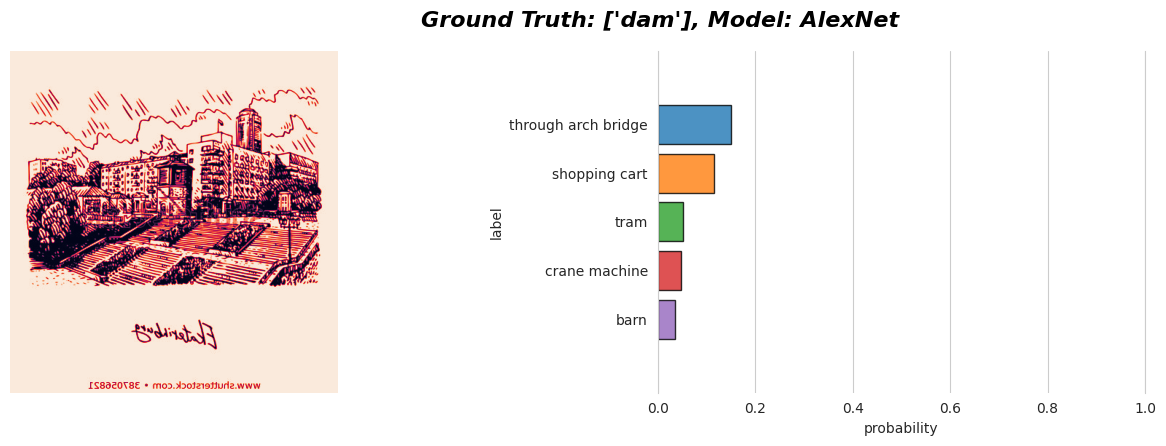

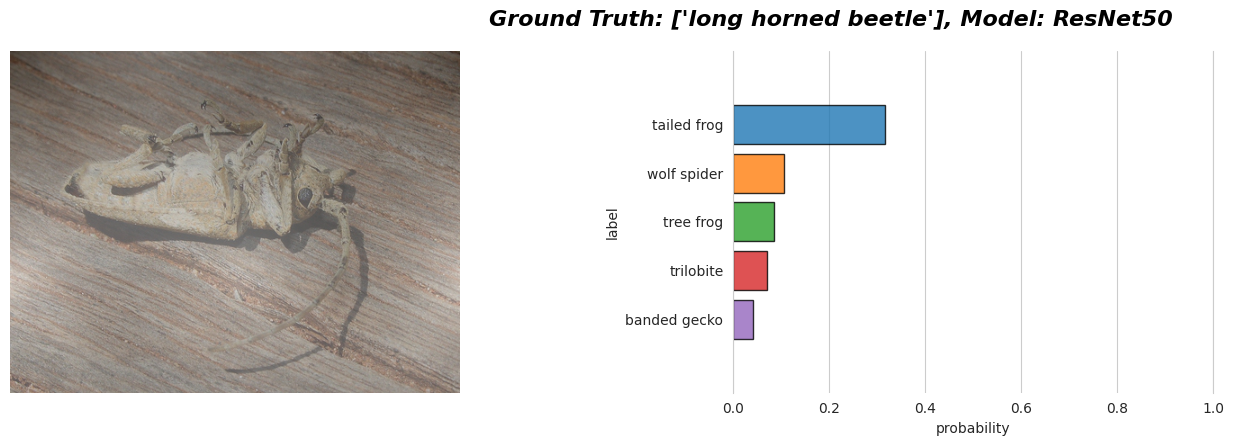

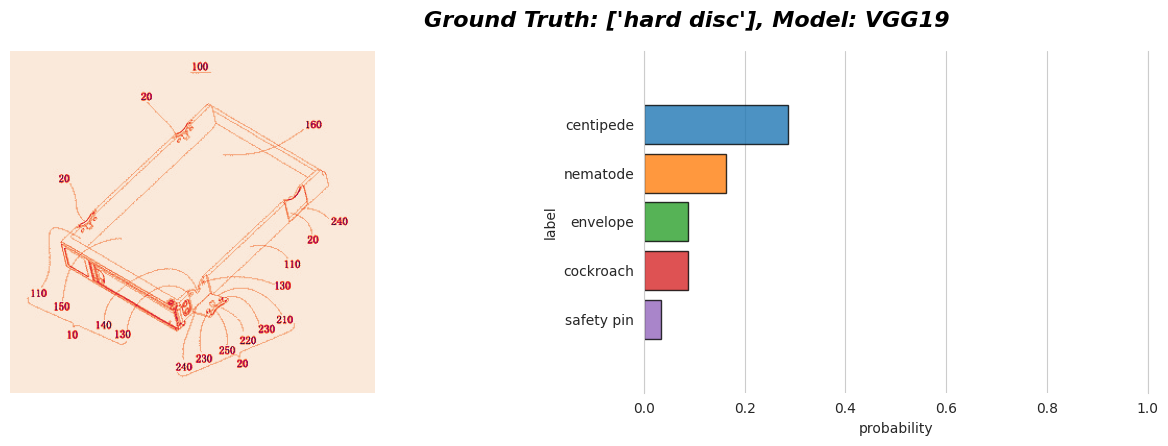

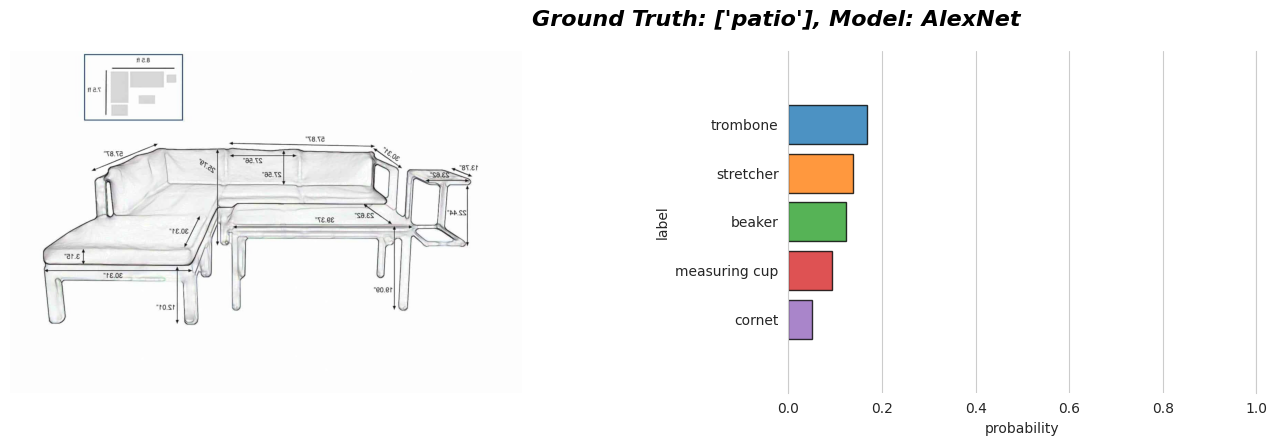

In [14]:
pretty_model_names = {
    "resnet50": "ResNet50",
    "resnet18": "ResNet18",
    "alexnet": "AlexNet",
    "vgg19": "VGG19",
    "vit_b_32": "ViT-B/32",
}

for i in np.random.randint(0, len(imagenet_hard_dataset), 4):
    rname = np.random.choice(model_names)
    model = models.__dict__[rname](pretrained=True)
    plot_image(model, pretty_model_names[rname], int(i))

### EfficientNet

In [15]:
import timm
model = timm.create_model("hf-hub:timm/tf_efficientnet_l2.ns_jft_in1k", pretrained=True)

In [16]:
enet_transform = transforms.Compose(
    [
        transforms.Resize(800),
        transforms.CenterCrop(800),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

def apply_transforms(examples):
    examples["pixel_values"] = examples["image"]
    examples["image"] = [enet_transform(image) for image in examples["image"]]
    return examples

imagenet_hard_dataset.set_transform(apply_transforms)

loader_effn = DataLoader(
    imagenet_hard_dataset, batch_size=8, num_workers=2, collate_fn=collate_fn
)

In [17]:
name = "efficientnet_l2_ns"
accuracy[name] = run_benchmark(model, loader=loader_effn)
print(f"{name} accuracy: {accuracy[name]}")

100%|██████████| 1741/1741 [16:42<00:00,  1.74it/s]

efficientnet_l2_ns accuracy: 33.54398563734291


In [18]:
pd.DataFrame(accuracy, index=["accuracy"]).T.round(2)

,accuracy
resnet50,12.29
resnet18,9.21
alexnet,6.24
vgg19,10.11
vit_b_32,15.63
efficientnet_l2_ns,33.54
